# EDA


#### Imports

In [1]:
from dotenv import find_dotenv, load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans
import time
from sklearn import metrics
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
import numpy as np
from warnings import filterwarnings
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

filterwarnings("ignore")



#### variables

In [2]:
PROJECT_PATH=os.getenv('PROJECT_PATH')
NUMBER_OF_GAMES_MINIMUM=int(os.getenv('NUMBER_OF_GAMES_MINIMUM'))

#### Load dataset

In [3]:
df=pd.read_csv(f"{PROJECT_PATH}/data/fics-build/proccessed/chess-games.csv")
df

#### Remove unnecceary columns and save the cleaned result

In [5]:
for c in [c for c in list(df.columns) if "Unnamed" in c]:
    df=df.drop(columns=c)
    
df["Year"]=df["Date"].apply(lambda r:r.split(".")[0])
df=df.drop(columns="Site")
df=df.drop(columns="WhiteIsComp")
df=df.drop(columns="BlackIsComp")
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean.csv")

#### Read the cleaned data for sanity

In [ ]:
df=pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean.csv")
df

#### Win rate

In [6]:
df["EloDiff"] = df["WhiteElo"] - df["BlackElo"]
df["RelativeEloDiff"] = (
    ((df["WhiteElo"] / (df[["WhiteElo", "BlackElo"]].median(axis=1))) - 1.0) * 100.0
).round(2)
display(df.head())

,Event,FICSGamesDBGameNo,White,Black,WhiteElo,BlackElo,WhiteRD,BlackRD,TimeControl,Date,Time,WhiteClock,BlackClock,ECO,PlyCount,Result,Move,Year,EloDiff,RelativeEloDiff
0,FICS rated blitz game,455505130,Strikko,boggus,1606,1607,23.3,22.4,180+0,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A27,156,0-1,| Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...,2019,-1,-0.03
1,FICS rated blitz game,455505129,Wychbold,Jarlaxle,1311,1437,27.7,24.1,180+0,2019.11.30,08:07:00,0:03:00.000,0:03:00.000,B21,60,0-1,| e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...,2019,-126,-4.59
2,FICS rated blitz game,455505128,Shaderman,tihibuda,1567,1516,53.1,27.5,180+0,2019.11.30,08:06:00,0:03:00.000,0:03:00.000,B06,75,1-0,| e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...,2019,51,1.65
3,FICS rated blitz game,455505126,aussenschnapp,SchachDieter,1680,1698,19.5,22.9,180+0,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A43,109,1-0,| d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...,2019,-18,-0.53
4,FICS rated blitz game,455505123,pfink,Tojul,1288,1174,26.2,46.2,600+0,2019.11.30,07:56:00,0:10:00.000,0:10:00.000,B94,71,0-1,| e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...,2019,114,4.63


In [7]:
def win_rate_by_elo_diff(df,elo_diff):
    try:
        win_freq=Counter(df[df["EloDiff"] > elo_diff]["Result"])
        white_won=win_freq["1-0"]
        draw=win_freq["1/2-1/2"]
        black_won=win_freq["0-1"]
        total=white_won+draw+black_won
        white_wins_proportion = white_won / total
        white_loss_proportion = black_won / total
        draw_proportion = draw / total
        return pd.DataFrame({
            'EloDiff':[elo_diff],
            'TotalGames':[total],
            'WhiteWon':[white_won],
            'WhiteWinsProportion':[white_wins_proportion],
            'WhiteLossProportion':[white_loss_proportion],
            'BlackWon':[black_won],
            'Draw':[draw],
            'DrawProportion':[draw_proportion],
        })
    except Exception as err:
           return pd.DataFrame({
            'EloDiff':[ ],
            'TotalGames':[ ],
            'WhiteWon':[ ],
            'WhiteWinsProportion':[ ],
            'WhiteLossProportion':[ ],
            'BlackWon':[ ],
            'Draw':[ ],
            'DrawProportion':[ ],
        })

Text(0.5, 1.0, 'Elo range group vs Count')

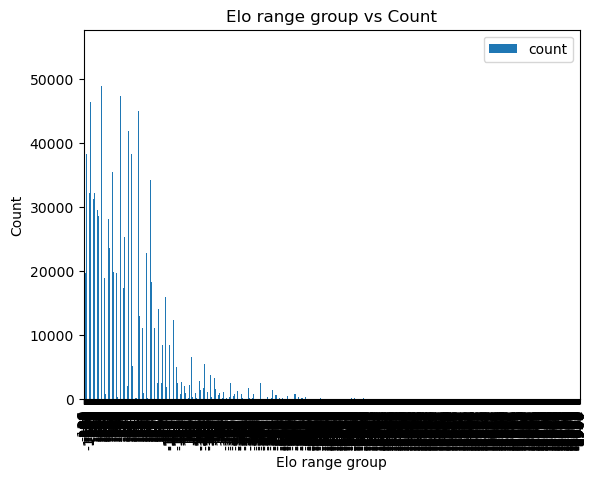

In [8]:
diffs=Counter(list(df["EloDiff"]))

freq_d={
    "amount":[],
    "count":[],
}

for k,v in diffs.items():
    freq_d["amount"].append(k)
    freq_d["count"].append(v)
    
df_freq=pd.DataFrame.from_dict(freq_d)
ax=df_freq.plot(kind='bar',x='amount',y='count')
ax.set_xlabel("Elo range group")
ax.set_ylabel("Count")
ax.set_title("Elo range group vs Count")



Text(0.5, 1.0, 'Elo range group vs Count')

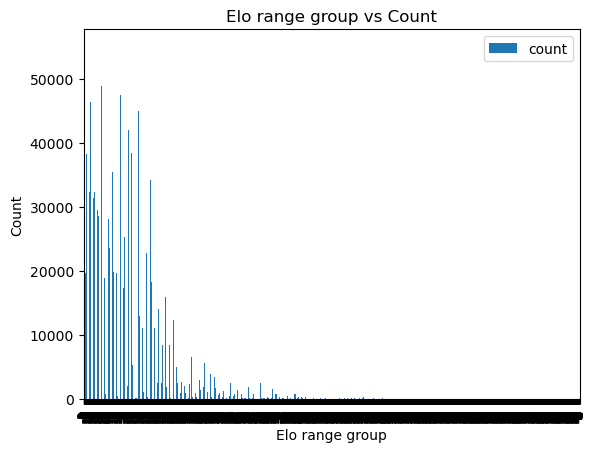

In [9]:
diffs=Counter(list(df["EloDiff"]))

freq_d={
    "amount":[],
    "count":[],
}

for k,v in diffs.items():
    freq_d["amount"].append(k//400)
    freq_d["count"].append(v)
    
df_freq=pd.DataFrame.from_dict(freq_d)
ax=df_freq.plot(kind='bar',x='amount',y='count')
ax.set_xlabel("Elo range group")
ax.set_ylabel("Count")
ax.set_title("Elo range group vs Count")



(-2351.694, -2310.328]    1
(-2310.328, -2273.656]    0
(-2273.656, -2236.984]    3
(-2236.984, -2200.312]    4
(-2200.312, -2163.641]    3
                         ..
(2163.641, 2200.312]      1
(2200.312, 2236.984]      3
(2236.984, 2273.656]      3
(2273.656, 2310.328]      1
(2310.328, 2347.0]        1
Name: count, Length: 128, dtype: int64


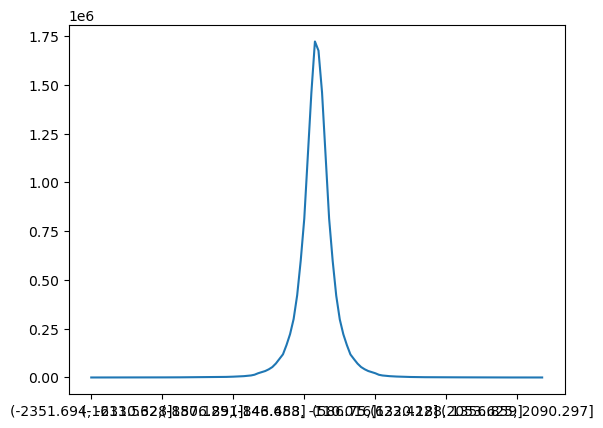

In [10]:
# counts, bin_edges = np.histogram(df_freq, bins=10)
# Creating bins
categories = pd.cut(list(df["EloDiff"]), bins=128)

# Getting the frequency distribution
frequency_distribution = categories.value_counts()

frequency_distribution.plot()
print(frequency_distribution)

In [11]:
all=sorted(list(df["EloDiff"]))

In [12]:
print(min(all),max(all))

-2347 2347


/tmp/ipykernel_5344/1829129545.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


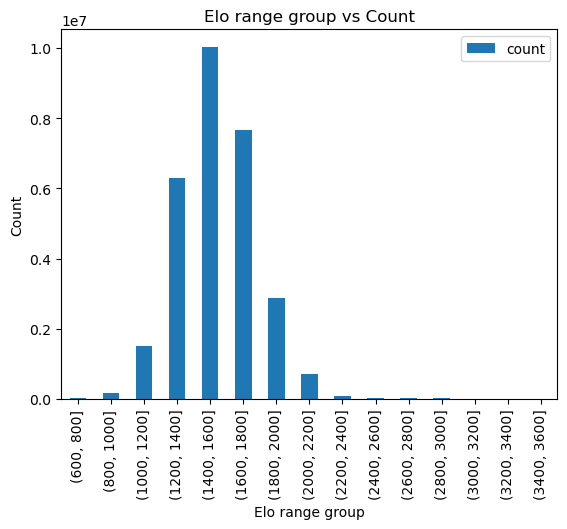

In [13]:
def get_elo_freq(df):
    freq_elo_black=Counter(list(df["BlackElo"]))
    freq_elo_white=Counter(list(df["WhiteElo"]))
    both={}
    for k,v in freq_elo_black.items():
        both[k]=v

    for k,v in freq_elo_white.items():
        both[k]=both.get(k,0)+v
    keys=list(both.keys())
    vals=list(both.values())
    frame=pd.DataFrame({
        'Elo':keys,
        'Count':vals,
    }).sort_values('Count',ascending=True)
    return frame




elo_freq=get_elo_freq(df)
elo_freq=elo_freq[["Elo","Count"]]
rating_bins = np.arange(600,3601, 200)
cuts=pd.cut(elo_freq["Elo"], bins=rating_bins)
elo_freq["group"]=cuts
groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]
elo_freq=pd.DataFrame.from_dict({'group':list(groups.index.astype(str)),'count':list(groups.values)})
ax=elo_freq.plot(kind='bar',x='group',y='count')
ax.set_xlabel("Elo range group")
ax.set_ylabel("Count")
ax.set_title("Elo range group vs Count")

ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-range-group-vs-Count-all-years.png")

-------------------------------------------------- Player ratio --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion
0,600.0,94510.0,90734.0,0.960047,0.032959,3115.0,661.0,0.006994
0,800.0,38619.0,37910.0,0.981641,0.014423,557.0,152.0,0.003936
0,1000.0,19612.0,19403.0,0.989343,0.007801,153.0,56.0,0.002855
0,1200.0,10978.0,10916.0,0.994352,0.003826,42.0,20.0,0.001822
0,1400.0,5847.0,5831.0,0.997264,0.002223,13.0,3.0,0.000513
0,1600.0,2313.0,2308.0,0.997838,0.002162,5.0,0.0,0.000000
0,1800.0,693.0,693.0,1.000000,0.000000,0.0,0.0,0.000000
0,2000.0,129.0,129.0,1.000000,0.000000,0.0,0.0,0.000000
0,2200.0,8.0,8.0,1.000000,0.000000,0.0,0.0,0.000000


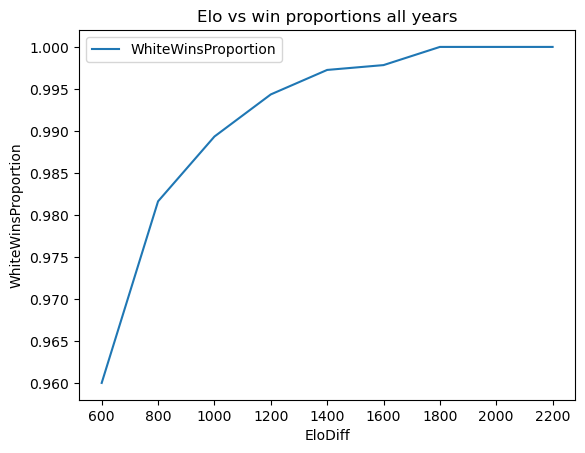

In [14]:
frames=[]
for diff in np.arange(600,3601, 200):
    frames.append(win_rate_by_elo_diff(df,diff))

frames_df=pd.concat(frames)
print("-"*50,"Player ratio","-"*50)
display(frames_df)
ax= frames_df.plot.line(x='EloDiff', y='WhiteWinsProportion')

ax.set_xlabel("EloDiff")
ax.set_ylabel("WhiteWinsProportion")
ax.set_title("Elo vs win proportions all years")

ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-vs-win-proportions-all-years.png")

-------------------------------------------------- Player ratio for year 2003 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion


-------------------------------------------------- Player ratio for year 2004 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion


-------------------------------------------------- Player ratio for year 2005 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion


-------------------------------------------------- Player ratio for year 2006 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion


-------------------------------------------------- Player ratio for year 2007 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion


-------------------------------------------------- Player ratio for year 2008 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion


-------------------------------------------------- Player ratio for year 2009 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion


-------------------------------------------------- Player ratio for year 2010 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion


-------------------------------------------------- Player ratio for year 2011 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion


-------------------------------------------------- Player ratio for year 2012 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion


-------------------------------------------------- Player ratio for year 2013 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion


-------------------------------------------------- Player ratio for year 2014 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion
0,600.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


-------------------------------------------------- Player ratio for year 2015 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion
0,600.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


-------------------------------------------------- Player ratio for year 2016 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion


-------------------------------------------------- Player ratio for year 2017 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion
0,600.0,5.0,4.0,0.8,0.2,1.0,0.0,0.0


-------------------------------------------------- Player ratio for year 2018 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion
0,600.0,38260.0,36638.0,0.957606,0.035180,1346.0,276.0,0.007214
0,800.0,16254.0,15942.0,0.980805,0.015258,248.0,64.0,0.003937
0,1000.0,8665.0,8584.0,0.990652,0.006463,56.0,25.0,0.002885
0,1200.0,4956.0,4927.0,0.994149,0.004237,21.0,8.0,0.001614
0,1400.0,2427.0,2417.0,0.995880,0.002884,7.0,3.0,0.001236
0,1600.0,967.0,964.0,0.996898,0.003102,3.0,0.0,0.000000
0,1800.0,267.0,267.0,1.000000,0.000000,0.0,0.0,0.000000
0,2000.0,40.0,40.0,1.000000,0.000000,0.0,0.0,0.000000


-------------------------------------------------- Player ratio for year 2019 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion
0,600.0,31504.0,30334.0,0.962862,0.030536,962.0,208.0,0.006602
0,800.0,13041.0,12813.0,0.982517,0.014723,192.0,36.0,0.002761
0,1000.0,6248.0,6169.0,0.987356,0.010723,67.0,12.0,0.001921
0,1200.0,3253.0,3237.0,0.995081,0.002767,9.0,7.0,0.002152
0,1400.0,1690.0,1688.0,0.998817,0.001183,2.0,0.0,0.000000
0,1600.0,583.0,583.0,1.000000,0.000000,0.0,0.0,0.000000
0,1800.0,164.0,164.0,1.000000,0.000000,0.0,0.0,0.000000
0,2000.0,30.0,30.0,1.000000,0.000000,0.0,0.0,0.000000
0,2200.0,4.0,4.0,1.000000,0.000000,0.0,0.0,0.000000


-------------------------------------------------- Player ratio for year 2020 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion
0,600.0,24739.0,23757.0,0.960306,0.032540,805.0,177.0,0.007155
0,800.0,9324.0,9155.0,0.981875,0.012548,117.0,52.0,0.005577
0,1000.0,4699.0,4650.0,0.989572,0.006384,30.0,19.0,0.004043
0,1200.0,2769.0,2752.0,0.993861,0.004334,12.0,5.0,0.001806
0,1400.0,1730.0,1726.0,0.997688,0.002312,4.0,0.0,0.000000
0,1600.0,763.0,761.0,0.997379,0.002621,2.0,0.0,0.000000
0,1800.0,262.0,262.0,1.000000,0.000000,0.0,0.0,0.000000
0,2000.0,59.0,59.0,1.000000,0.000000,0.0,0.0,0.000000
0,2200.0,4.0,4.0,1.000000,0.000000,0.0,0.0,0.000000


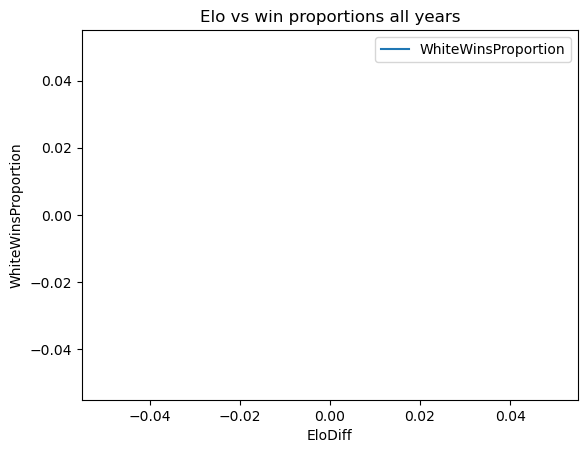

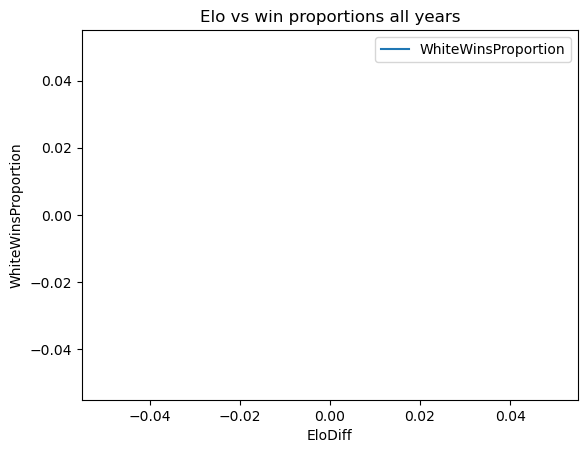

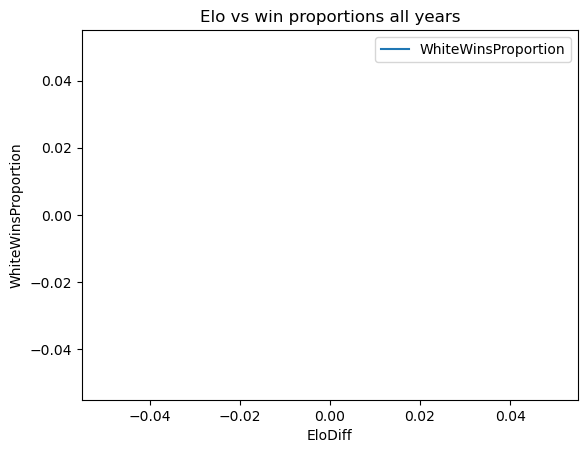

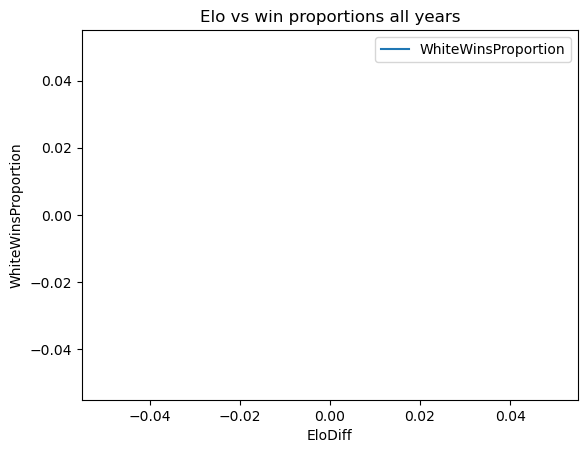

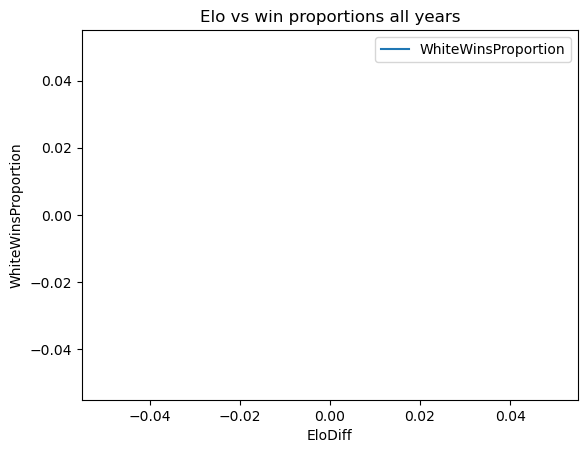

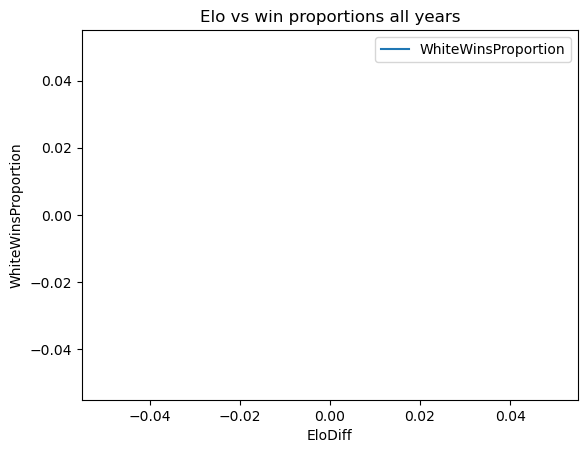

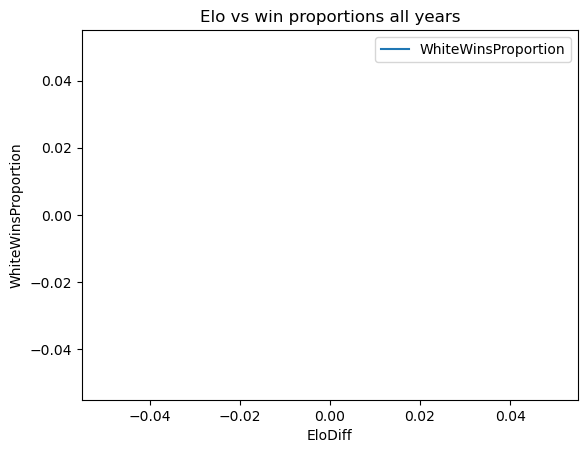

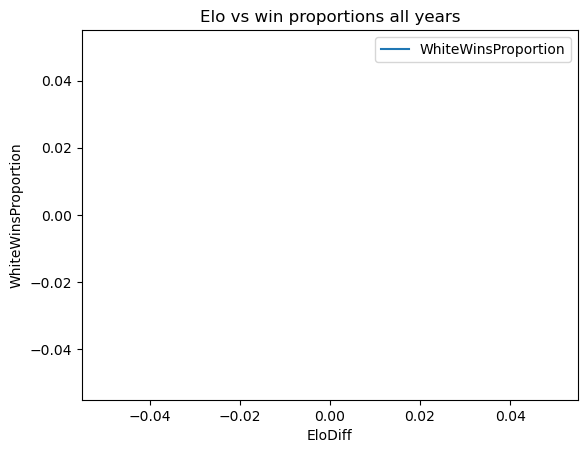

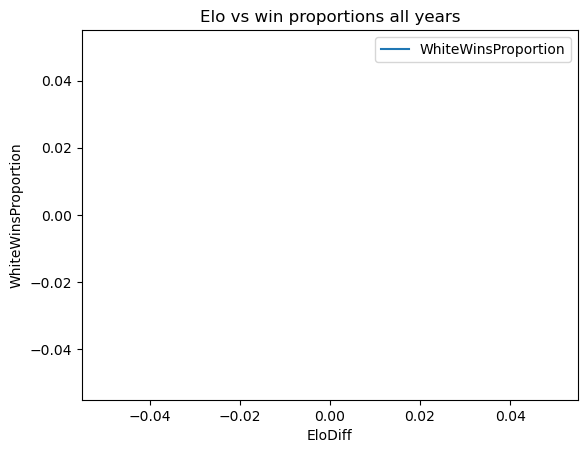

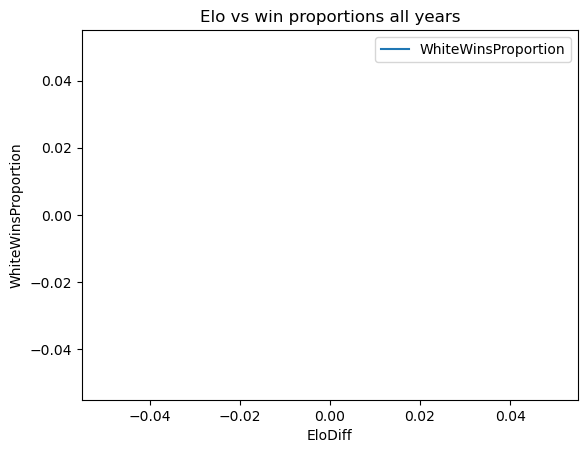

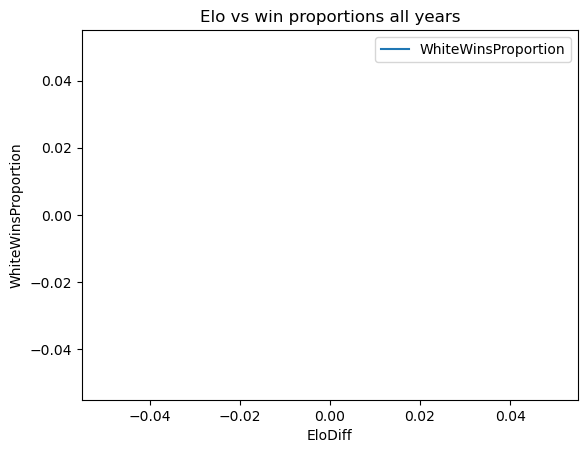

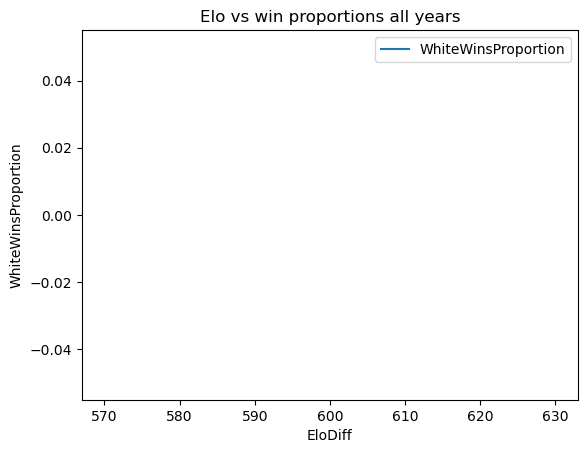

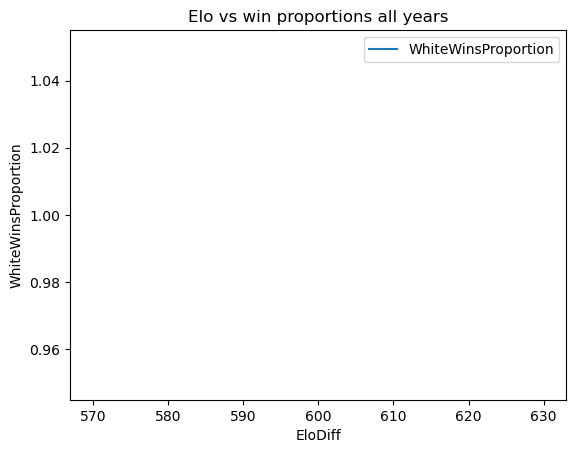

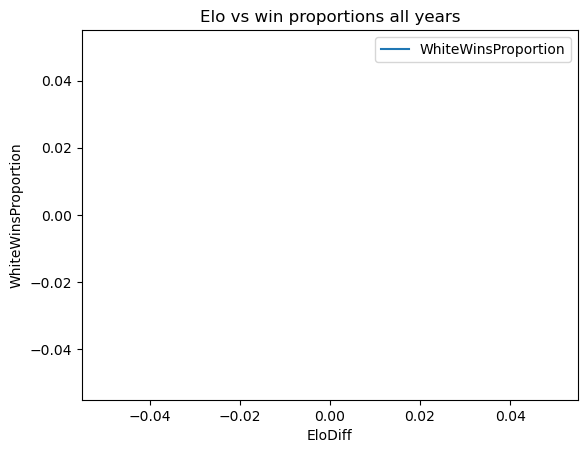

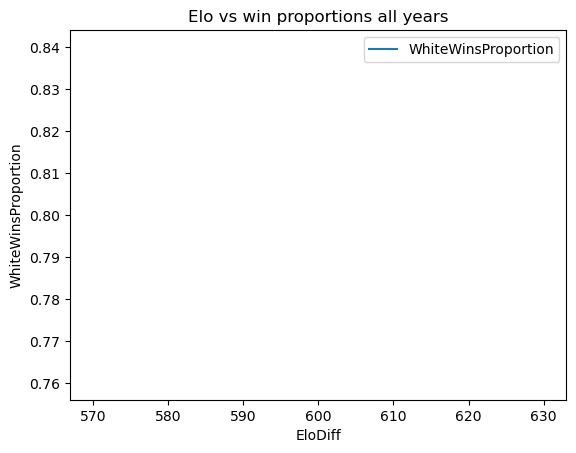

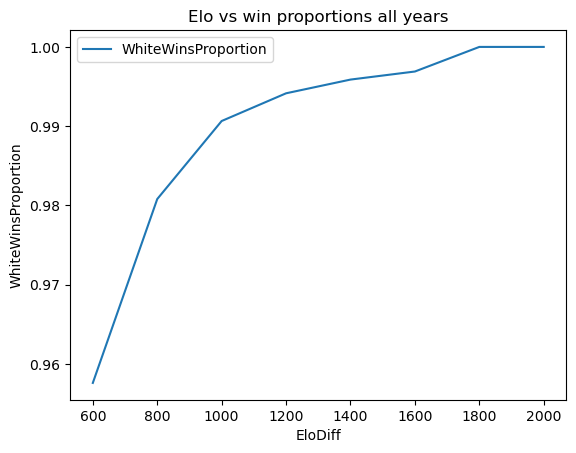

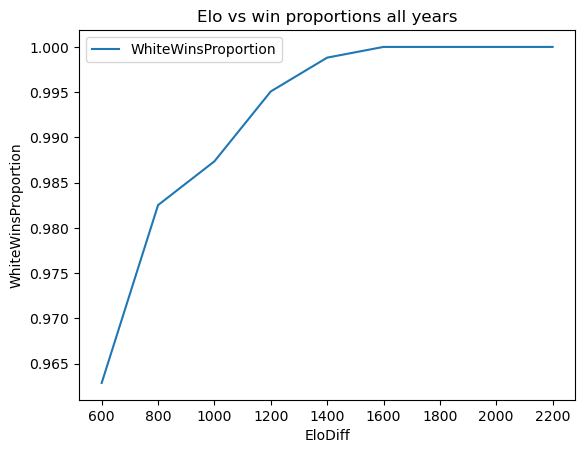

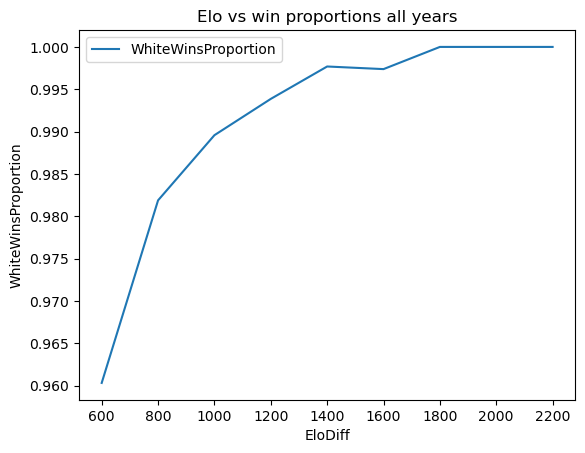

In [15]:

for year in sorted(list(set(df["Year"]))):
    frames=[]
    for diff in np.arange(600,3601, 200):
        frames.append(win_rate_by_elo_diff(df[df["Year"]==year],diff))

    frames_df=pd.concat(frames)

    frames_df=pd.concat(frames)
    print("-"*50,"Player ratio for year",year,"-"*50)
    display(frames_df)
    ax= frames_df.plot.line(x='EloDiff', y='WhiteWinsProportion')

    ax.set_xlabel("EloDiff")
    ax.set_ylabel("WhiteWinsProportion")
    ax.set_title("Elo vs win proportions all years")

    ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-vs-win-proportions-{year}.png")

In [16]:
win_freq2=Counter(df[df["EloDiff"] > 20]["Result"])
white_won2=win_freq2["1-0"]
draw2=win_freq2["1/2-1/2"]
black_won2=win_freq2["0-1"]
total2=white_won2+draw2+black_won2
white_wins_proportion2 = white_won2 / total2
white_loss_proportion2 = black_won2 / total2
draw_proportion2 = draw2 / total2
print(
    f"Out of {total2} games:\n  White won {white_won2} games "
    f"({white_wins_proportion2:.2%}).\n  White lost {black_won2} games "
    f"({white_loss_proportion2:.2%}).\n"
    f"  White draw {draw2} games ({draw_proportion2:.2%}).  "
)

Out of 6377852 games:
  White won 4130191 games (64.76%).
  White lost 2011232 games (31.53%).
  White draw 236429 games (3.71%).  


#### Elo distributions

In [17]:
def get_elo_freq(df):
    freq_elo_black=Counter(list(df["BlackElo"]))
    freq_elo_white=Counter(list(df["WhiteElo"]))
    both={}
    for k,v in freq_elo_black.items():
        both[k]=v

    for k,v in freq_elo_white.items():
        both[k]=both.get(k,0)+v
    keys=list(both.keys())
    vals=list(both.values())
    frame=pd.DataFrame({
        'Elo':keys,
        'Count':vals,
    }).sort_values('Count',ascending=True)
    print(min(keys))
    print(max(keys))
    return frame

228
3293


/tmp/ipykernel_5344/2039240596.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


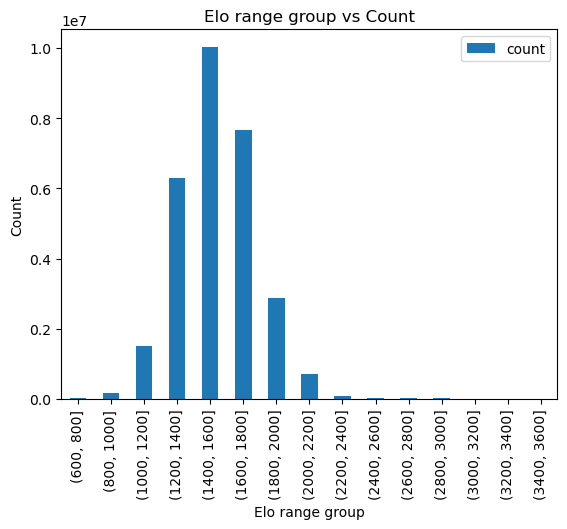

In [18]:
elo_freq=get_elo_freq(df)
elo_freq=elo_freq[["Elo","Count"]]
rating_bins = np.arange(600,3601, 200)
cuts=pd.cut(elo_freq["Elo"], bins=rating_bins)
elo_freq["group"]=cuts
groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]
elo_freq=pd.DataFrame.from_dict({'group':list(groups.index.astype(str)),'count':list(groups.values)})
ax=elo_freq.plot(kind='bar',x='group',y='count')
ax.set_xlabel("Elo range group")
ax.set_ylabel("Count")
ax.set_title("Elo range group vs Count")

ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-range-group-vs-Count-all-years.png")

In [19]:
(3500-300)/128

25.0

In [20]:
groups={str(k):[] for k in range(300,3500,25)}
groups

{'300': [],
 '325': [],
 '350': [],
 '375': [],
 '400': [],
 '425': [],
 '450': [],
 '475': [],
 '500': [],
 '525': [],
 '550': [],
 '575': [],
 '600': [],
 '625': [],
 '650': [],
 '675': [],
 '700': [],
 '725': [],
 '750': [],
 '775': [],
 '800': [],
 '825': [],
 '850': [],
 '875': [],
 '900': [],
 '925': [],
 '950': [],
 '975': [],
 '1000': [],
 '1025': [],
 '1050': [],
 '1075': [],
 '1100': [],
 '1125': [],
 '1150': [],
 '1175': [],
 '1200': [],
 '1225': [],
 '1250': [],
 '1275': [],
 '1300': [],
 '1325': [],
 '1350': [],
 '1375': [],
 '1400': [],
 '1425': [],
 '1450': [],
 '1475': [],
 '1500': [],
 '1525': [],
 '1550': [],
 '1575': [],
 '1600': [],
 '1625': [],
 '1650': [],
 '1675': [],
 '1700': [],
 '1725': [],
 '1750': [],
 '1775': [],
 '1800': [],
 '1825': [],
 '1850': [],
 '1875': [],
 '1900': [],
 '1925': [],
 '1950': [],
 '1975': [],
 '2000': [],
 '2025': [],
 '2050': [],
 '2075': [],
 '2100': [],
 '2125': [],
 '2150': [],
 '2175': [],
 '2200': [],
 '2225': [],
 '2250': [],
 

1655
1872


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


1614
1892


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


981
1238


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


729
1687


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


890
1857


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


807
1772


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


675
1679


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


602
1774


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


746
1978


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


828
1972


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


791
1961


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


832
2213


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


940
2139


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


583
2077


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


726
2423


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


228
3261


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


447
3293


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


312
3046


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


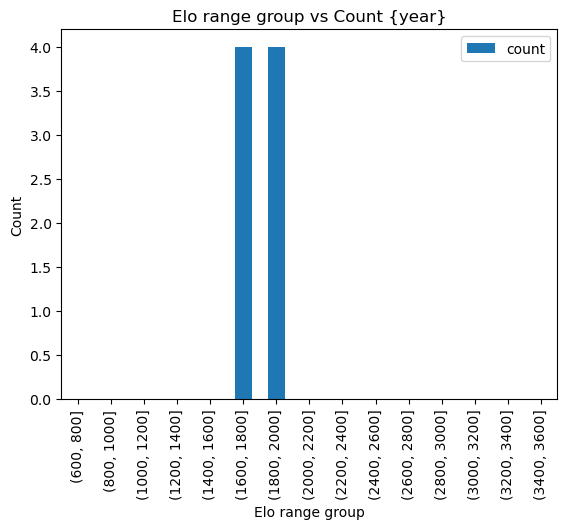

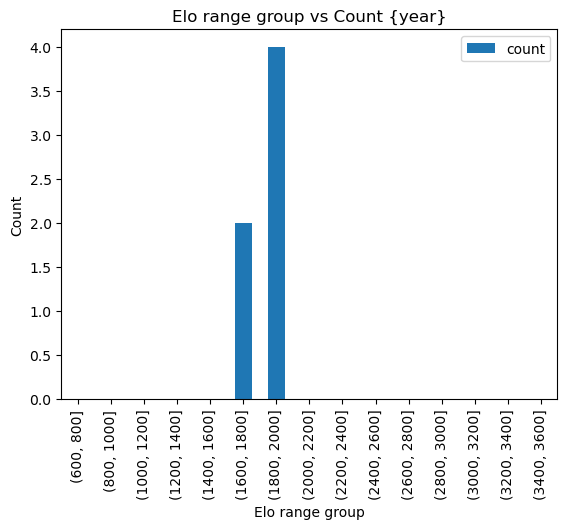

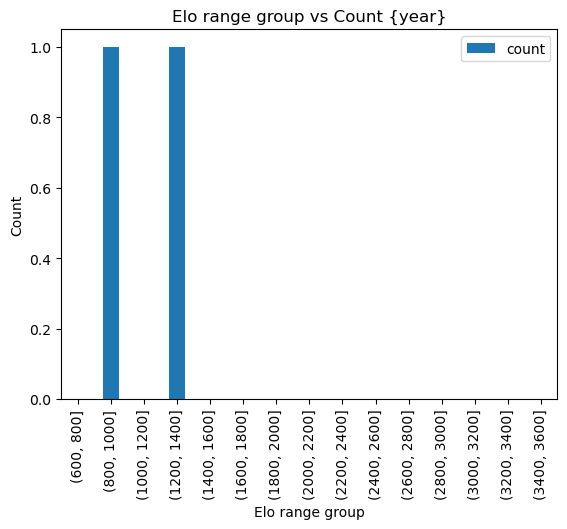

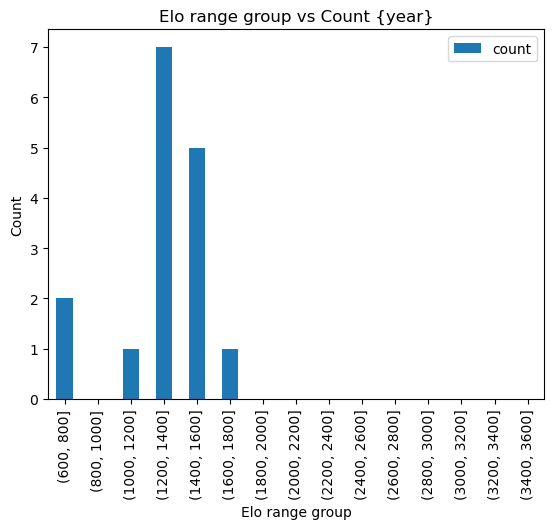

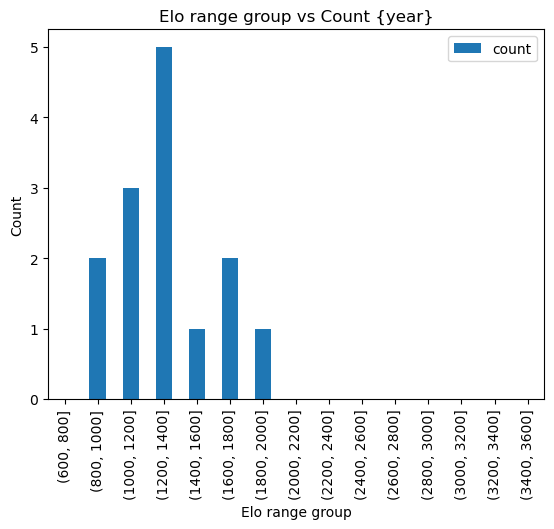

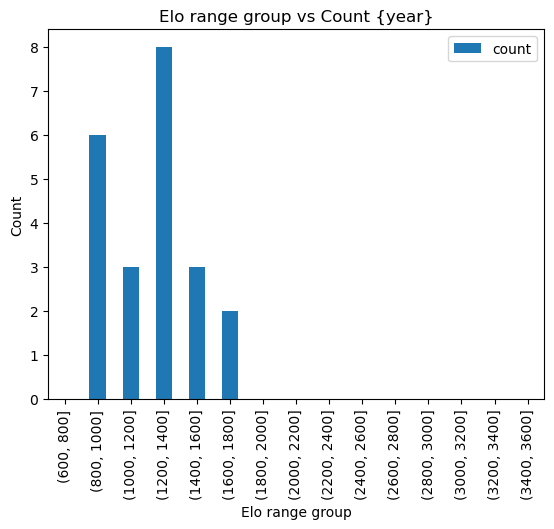

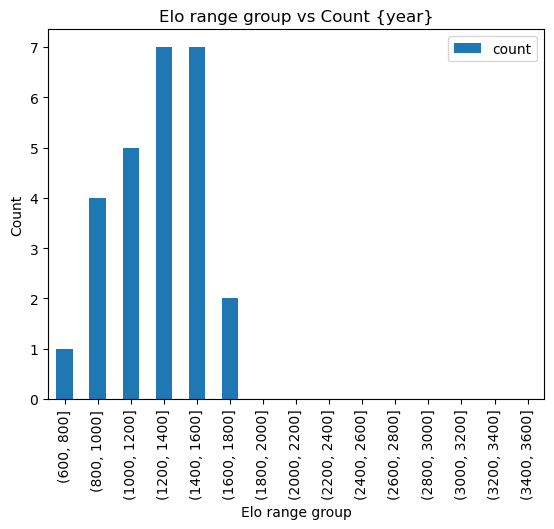

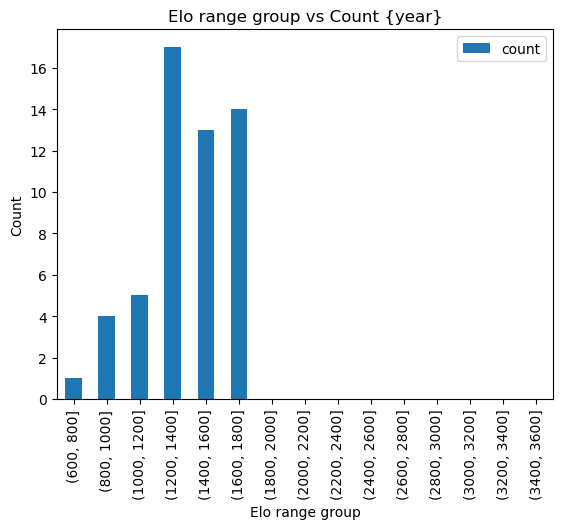

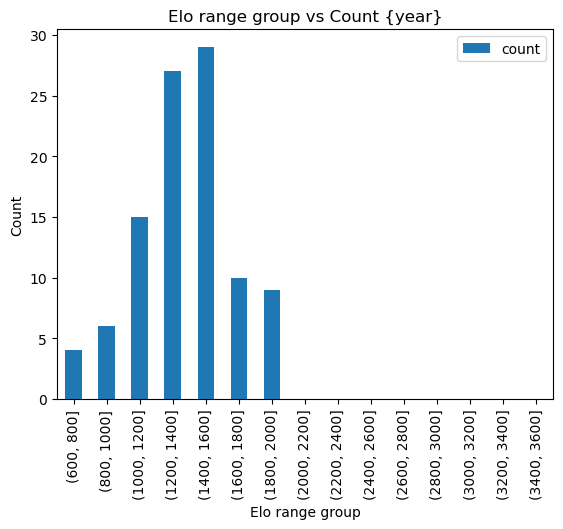

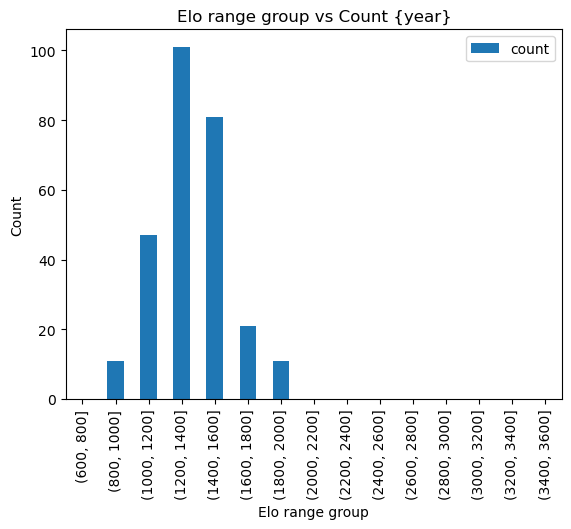

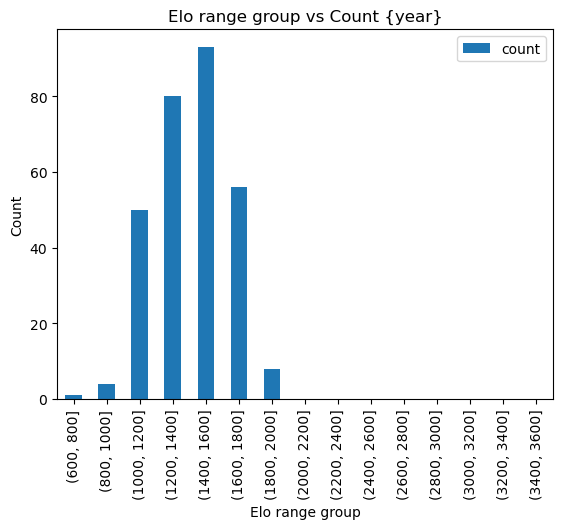

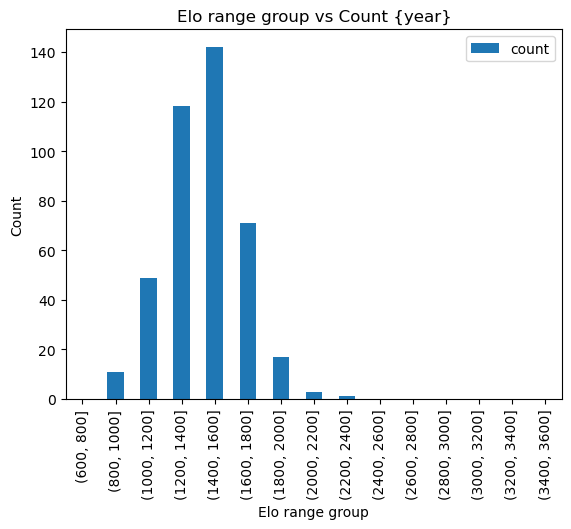

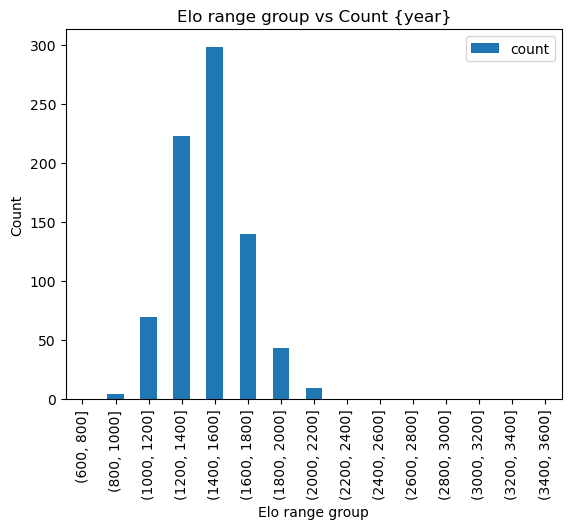

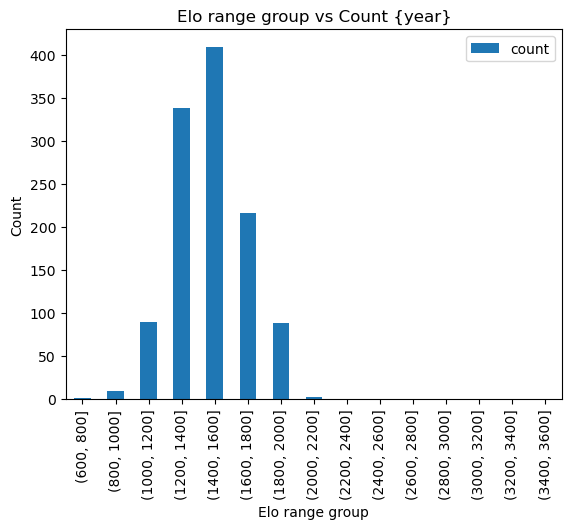

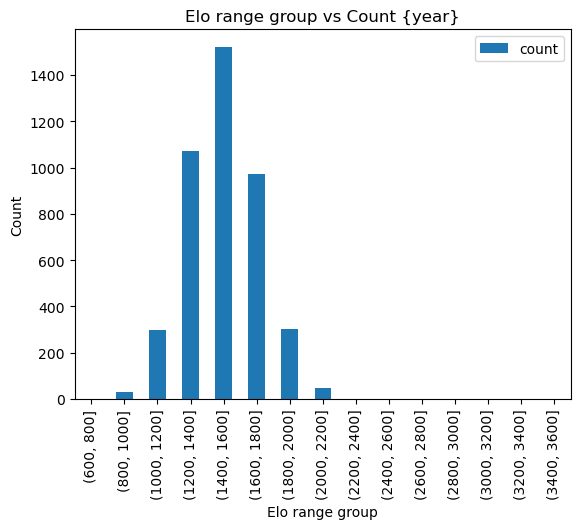

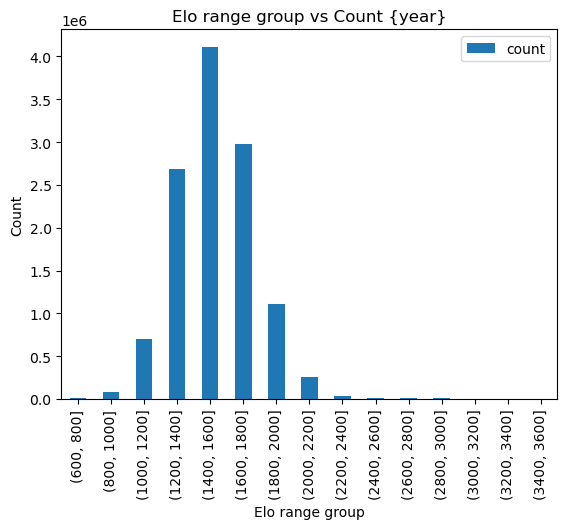

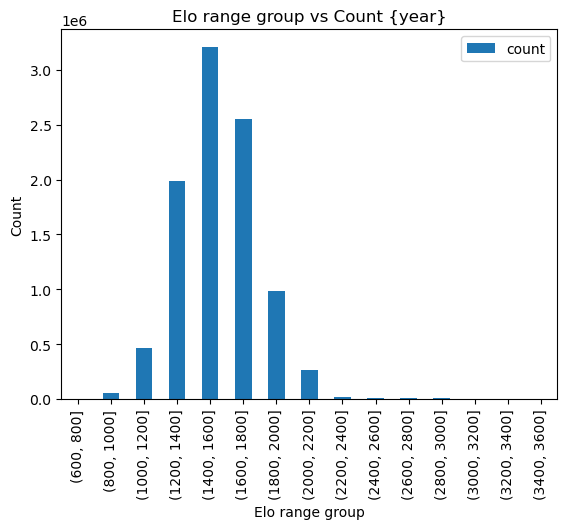

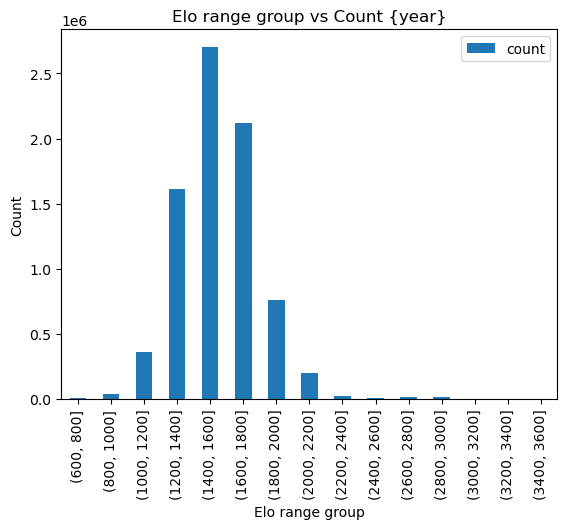

In [21]:
for year in sorted(list(set(df["Year"]))):
    elo_freq=get_elo_freq(df[df["Year"]==year])
    elo_freq=elo_freq[["Elo","Count"]]
    rating_bins = np.arange(600,3601, 200)
    cuts=pd.cut(elo_freq["Elo"], bins=rating_bins)
    elo_freq["group"]=cuts
    groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]
    elo_freq=pd.DataFrame.from_dict({'group':list(groups.index.astype(str)),'count':list(groups.values)})
    ax=elo_freq.plot(kind='bar',x='group',y='count')
    ax.set_title(f"Elo range group vs count for {year}")
    ax.set_xlabel("Elo range group")
    ax.set_ylabel("Count")
    ax.set_title("Elo range group vs Count {year}")
    ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-range-group-vs-Count-{year}.png")

228
3293


/tmp/ipykernel_5344/2052553180.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


395
3285


/tmp/ipykernel_5344/2052553180.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


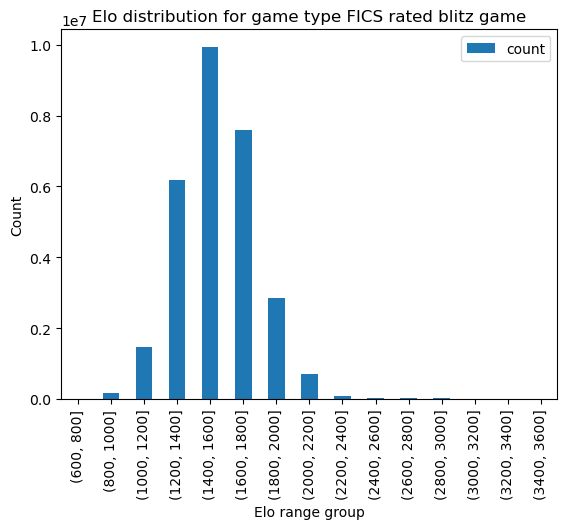

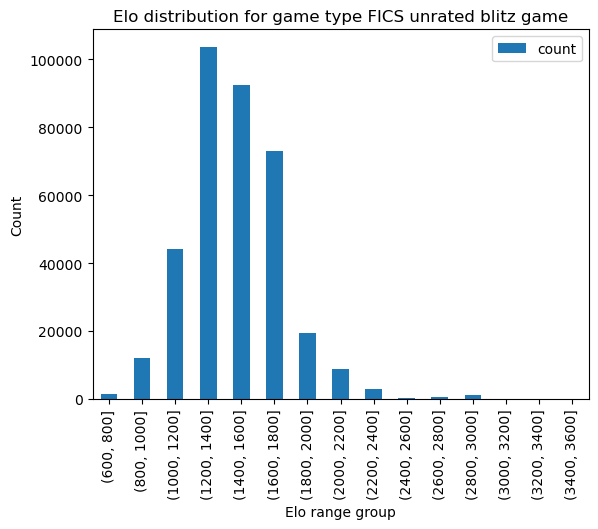

In [22]:
events=list(set(list(df["Event"])))


for e in events:
    df_e=df[df["Event"]==e]

    elo_freq=get_elo_freq(df_e)
    elo_freq=elo_freq[["Elo","Count"]]
    rating_bins = np.arange(600,3601, 200)
    cuts=pd.cut(elo_freq["Elo"], bins=rating_bins)
    elo_freq["group"]=cuts
    groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]
    elo_freq=pd.DataFrame.from_dict({'group':list(groups.index.astype(str)),'count':list(groups.values)})
    ax=elo_freq.plot(kind='bar',x='group',y='count')
    ax.set_xlabel("Elo range group")
    ax.set_ylabel("Count")
    ax.set_title(f"Elo distribution for game type {e}")
    ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-range-group-vs-Count-all-years-{e}.png")

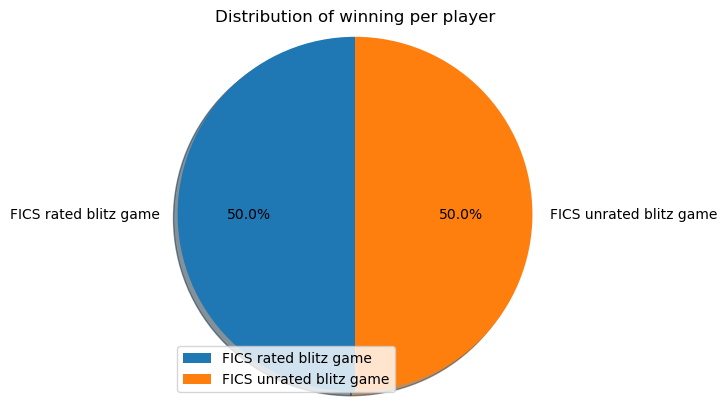

In [23]:
import matplotlib.pyplot as plt


by_event={e:len(df["Event"]==e) for e in list(set(list(df["Event"])))}
# defining labels
activities = list(by_event.keys())

# portion covered by each label
slices = list(by_event.values())

# color for each label
colors = ['r', 'y', 'g', 'b']

# plotting the pie chart
ax=plt.pie(slices, labels = activities,
        startangle=90, shadow = True,
        radius = 1.2, autopct = '%1.1f%%')

# plotting legend
plt.legend()
plt.title("Distribution of winning per player")


plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/Distribution-of-winning-per-player-all-years-{e}.png")

# showing the plot
plt.show()


#### Number of games distributions

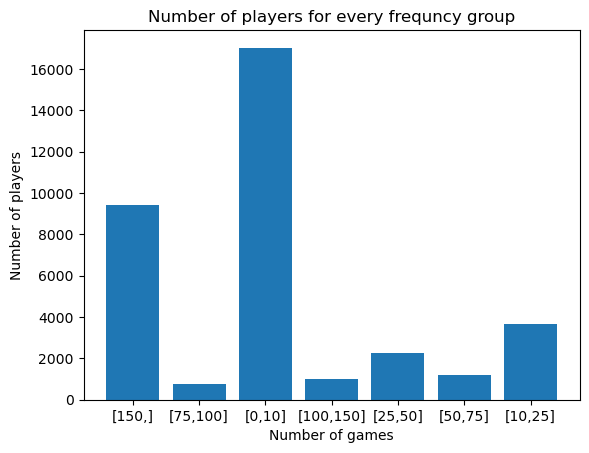

In [24]:
from collections import Counter
white_freq=Counter(list(df["White"]))
black_freq=Counter(list(df["Black"]))
all_freq=white_freq

for k,v in black_freq.items():
    all_freq[k]=all_freq.get(k,0)+v

count_freq={}
for k,v in all_freq.items():
    if v <=10:
        count_freq["[0,10]"]=count_freq.get("[0,10]",0)+1
    elif v <=25:
        count_freq["[10,25]"]=count_freq.get("[10,25]",0)+1
    elif v <=50:
        count_freq["[25,50]"]=count_freq.get("[25,50]",0)+1
    elif v <=75:
        count_freq["[50,75]"]=count_freq.get("[50,75]",0)+1
    elif v <=100:
        count_freq["[75,100]"]=count_freq.get("[75,100]",0)+1
    elif v <=150:
        count_freq["[100,150]"]=count_freq.get("[100,150]",0)+1
    else:
        count_freq["[150,]"]=count_freq.get("[150,]",0)+1

x = list(count_freq.keys())
y = list(count_freq.values())
plt.xlabel('Number of games')
plt.ylabel('Number of players')
plt.title('Number of players for every frequncy group')
plt.bar( x, y)
plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/Number-of-players-for-every-frequncy-group.png")


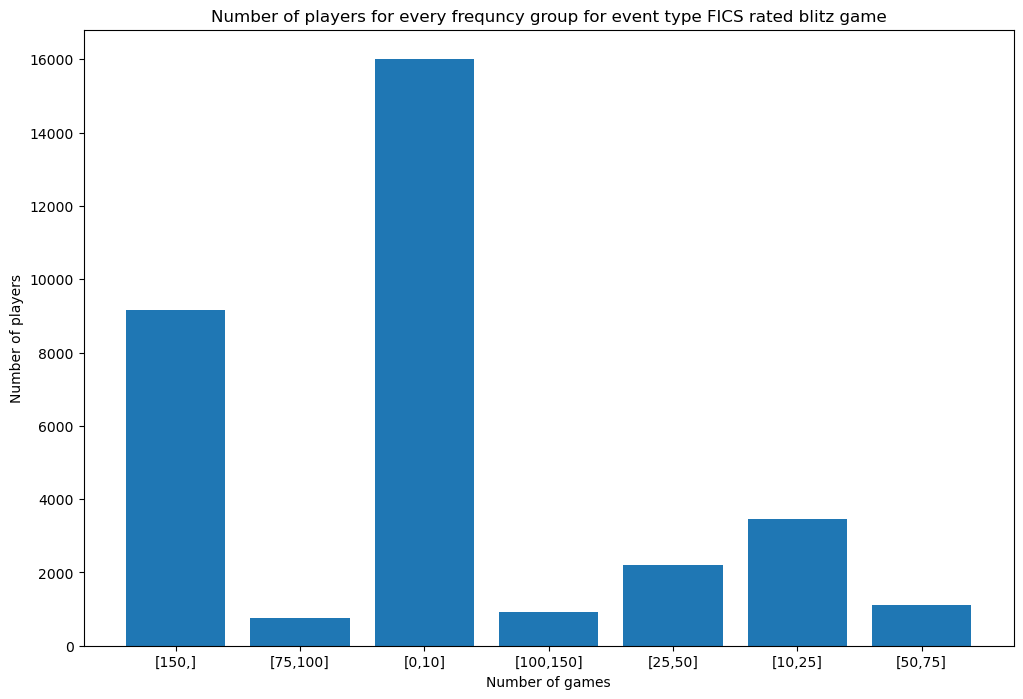

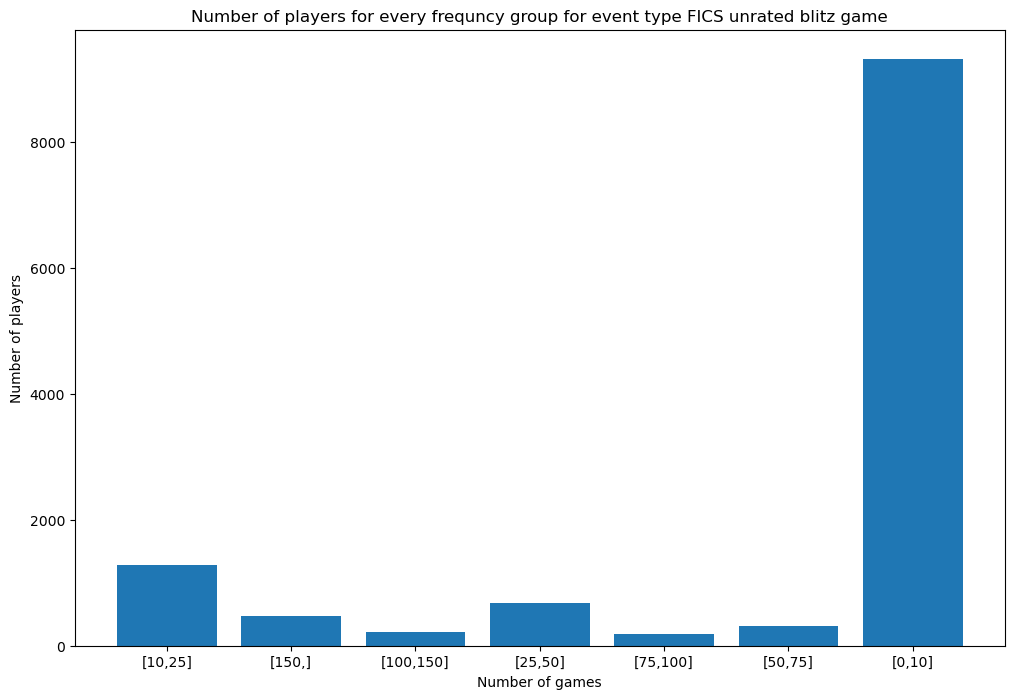

In [25]:
from collections import Counter

events=list(set(list(df["Event"])))


for e in events:
    df_e=df[df["Event"]==e]
    white_freq=Counter(list(df_e["White"]))
    black_freq=Counter(list(df_e["Black"]))
    all_freq=white_freq

    for k,v in black_freq.items():
        all_freq[k]=all_freq.get(k,0)+v

    count_freq={}
    for k,v in all_freq.items():
        if v <=10:
            count_freq["[0,10]"]=count_freq.get("[0,10]",0)+1
        elif v <=25:
            count_freq["[10,25]"]=count_freq.get("[10,25]",0)+1
        elif v <=50:
            count_freq["[25,50]"]=count_freq.get("[25,50]",0)+1
        elif v <=75:
            count_freq["[50,75]"]=count_freq.get("[50,75]",0)+1
        elif v <=100:
            count_freq["[75,100]"]=count_freq.get("[75,100]",0)+1
        elif v <=150:
            count_freq["[100,150]"]=count_freq.get("[100,150]",0)+1
        else:
            count_freq["[150,]"]=count_freq.get("[150,]",0)+1
    plt.figure(figsize=(12, 8))
    x = list(count_freq.keys())
    y = list(count_freq.values())
    plt.xlabel('Number of games')
    plt.ylabel('Number of players')
    plt.title(f'Number of players for every frequncy group for event type {e}')
    plt.bar( x, y)
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/Number-of-players-for-every-frequncy-group-for-event-type-{e}.png")


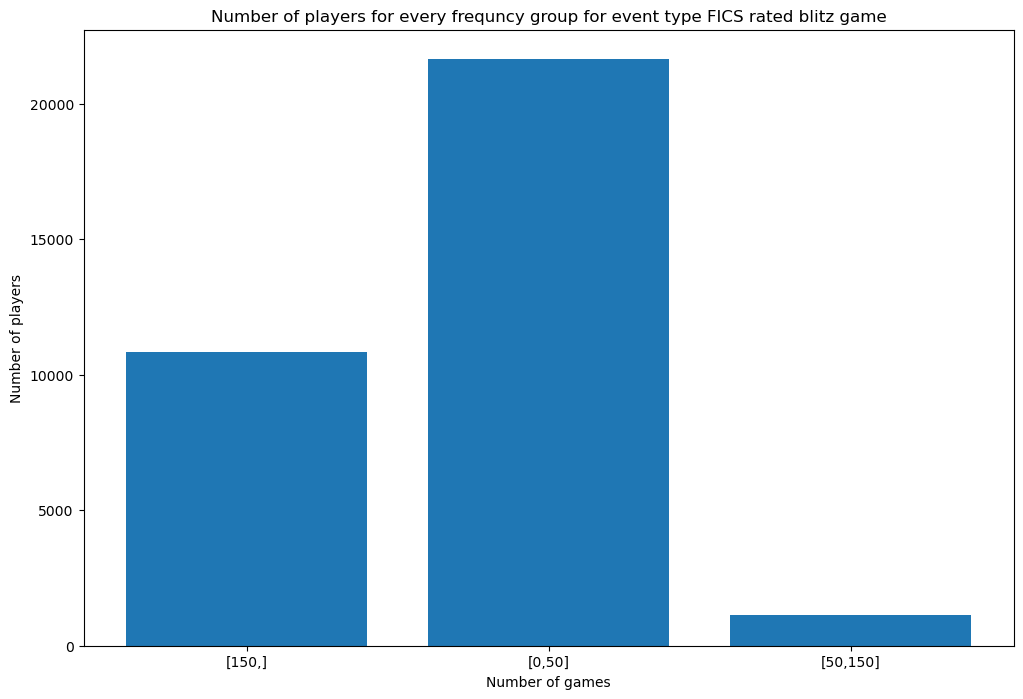

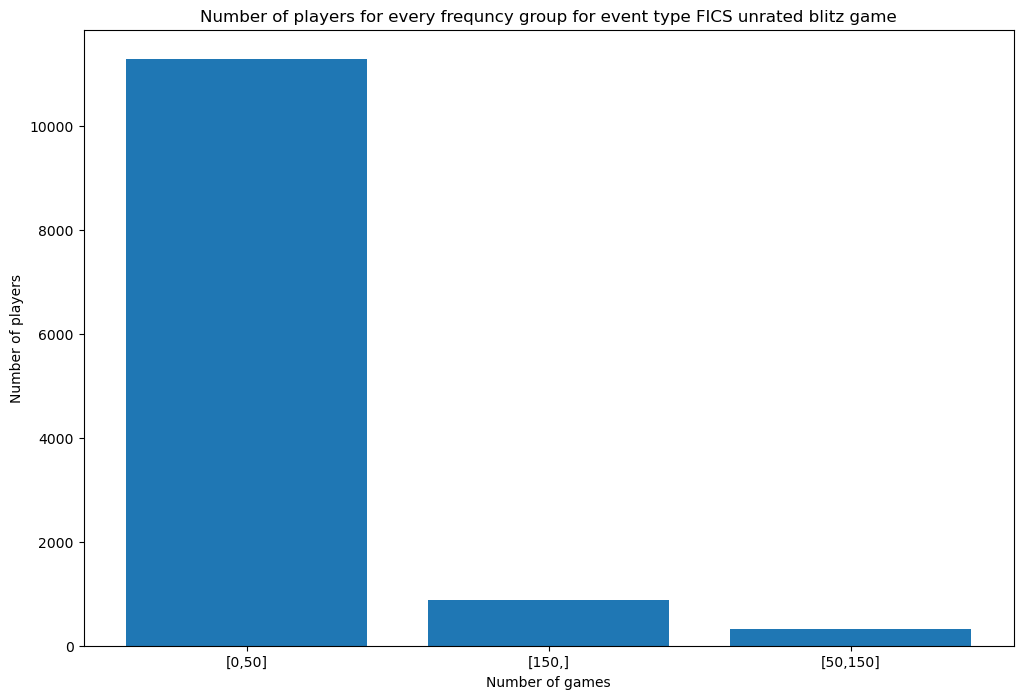

In [26]:
from collections import Counter

events=list(set(list(df["Event"])))


for e in events:
    df_e=df[df["Event"]==e]
    white_freq=Counter(list(df_e["White"]))
    black_freq=Counter(list(df_e["Black"]))
    all_freq=white_freq

    for k,v in black_freq.items():
        all_freq[k]=all_freq.get(k,0)+v

    count_freq={}
    for k,v in all_freq.items():
        if v <=50:
            count_freq["[0,50]"]=count_freq.get("[0,50]",0)+1
        elif v <=75:
            count_freq["[50,150]"]=count_freq.get("[50,150]",0)+1
        else:
            count_freq["[150,]"]=count_freq.get("[150,]",0)+1
    plt.figure(figsize=(12, 8))
    x = list(count_freq.keys())
    y = list(count_freq.values())
    plt.xlabel('Number of games')
    plt.ylabel('Number of players')
    plt.title(f'Number of players for every frequncy group for event type {e}')
    plt.bar( x, y)
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/Number-of-players-for-every-frequncy-group-event-{e}-less_grouping.png")


In [27]:
df

,Event,FICSGamesDBGameNo,White,Black,WhiteElo,BlackElo,WhiteRD,BlackRD,TimeControl,Date,Time,WhiteClock,BlackClock,ECO,PlyCount,Result,Move,Year,EloDiff,RelativeEloDiff
0,FICS rated blitz game,455505130,Strikko,boggus,1606,1607,23.3,22.4,180+0,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A27,156,0-1,| Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...,2019,-1,-0.03
1,FICS rated blitz game,455505129,Wychbold,Jarlaxle,1311,1437,27.7,24.1,180+0,2019.11.30,08:07:00,0:03:00.000,0:03:00.000,B21,60,0-1,| e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...,2019,-126,-4.59
2,FICS rated blitz game,455505128,Shaderman,tihibuda,1567,1516,53.1,27.5,180+0,2019.11.30,08:06:00,0:03:00.000,0:03:00.000,B06,75,1-0,| e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...,2019,51,1.65
3,FICS rated blitz game,455505126,aussenschnapp,SchachDieter,1680,1698,19.5,22.9,180+0,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A43,109,1-0,| d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...,2019,-18,-0.53
4,FICS rated blitz game,455505123,pfink,Tojul,1288,1174,26.2,46.2,600+0,2019.11.30,07:56:00,0:10:00.000,0:10:00.000,B94,71,0-1,| e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...,2019,114,4.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14717855,FICS rated blitz game,434845469,Arembepe,bretteux,1059,1155,46.6,28.1,180+1,2018.08.09,12:16:00,0:03:00.000,0:03:00.000,B20,47,1-0,| e4 c5 | Bc4 a6 | a3 Nc6 | d3 h6 | h3 Nf6 | N...,2018,-96,-4.34
14717856,FICS rated blitz game,434845468,JonotheRed,HWPer,1501,1520,27.1,33.7,300+0,2018.08.09,12:12:00,0:05:00.000,0:05:00.000,C01,109,1-0,| e4 e6 | Nf3 d5 | exd5 exd5 | d4 Nf6 | Bd3 Bd...,2018,-19,-0.63
14717857,FICS rated blitz game,434845467,snackking,Jonfern,1621,1676,18.9,26.6,180+0,2018.08.09,12:13:00,0:03:00.000,0:03:00.000,C50,80,0-1,| e4 e5 | Nf3 Nc6 | Bc4 Be7 | O-O Nf6 | Re1 O-...,2018,-55,-1.67
14717858,FICS rated blitz game,434845465,alza,Jesuslovesall,1333,1423,19.9,21.0,300+0,2018.08.09,12:14:00,0:05:00.000,0:05:00.000,B01,42,0-1,| e4 d5 | e5 c5 | d4 Nc6 | dxc5 Nxe5 | Nf3 Nc6...,2018,-90,-3.27


In [30]:
df=df[df["Event"]=="FICS rated blitz game"]
df=df.drop(columns="Event")
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated.csv")

In [31]:
df

,FICSGamesDBGameNo,White,Black,WhiteElo,BlackElo,WhiteRD,BlackRD,TimeControl,Date,Time,WhiteClock,BlackClock,ECO,PlyCount,Result,Move,Year,EloDiff,RelativeEloDiff
0,455505130,Strikko,boggus,1606,1607,23.3,22.4,180+0,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A27,156,0-1,| Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...,2019,-1,-0.03
1,455505129,Wychbold,Jarlaxle,1311,1437,27.7,24.1,180+0,2019.11.30,08:07:00,0:03:00.000,0:03:00.000,B21,60,0-1,| e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...,2019,-126,-4.59
2,455505128,Shaderman,tihibuda,1567,1516,53.1,27.5,180+0,2019.11.30,08:06:00,0:03:00.000,0:03:00.000,B06,75,1-0,| e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...,2019,51,1.65
3,455505126,aussenschnapp,SchachDieter,1680,1698,19.5,22.9,180+0,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A43,109,1-0,| d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...,2019,-18,-0.53
4,455505123,pfink,Tojul,1288,1174,26.2,46.2,600+0,2019.11.30,07:56:00,0:10:00.000,0:10:00.000,B94,71,0-1,| e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...,2019,114,4.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14717855,434845469,Arembepe,bretteux,1059,1155,46.6,28.1,180+1,2018.08.09,12:16:00,0:03:00.000,0:03:00.000,B20,47,1-0,| e4 c5 | Bc4 a6 | a3 Nc6 | d3 h6 | h3 Nf6 | N...,2018,-96,-4.34
14717856,434845468,JonotheRed,HWPer,1501,1520,27.1,33.7,300+0,2018.08.09,12:12:00,0:05:00.000,0:05:00.000,C01,109,1-0,| e4 e6 | Nf3 d5 | exd5 exd5 | d4 Nf6 | Bd3 Bd...,2018,-19,-0.63
14717857,434845467,snackking,Jonfern,1621,1676,18.9,26.6,180+0,2018.08.09,12:13:00,0:03:00.000,0:03:00.000,C50,80,0-1,| e4 e5 | Nf3 Nc6 | Bc4 Be7 | O-O Nf6 | Re1 O-...,2018,-55,-1.67
14717858,434845465,alza,Jesuslovesall,1333,1423,19.9,21.0,300+0,2018.08.09,12:14:00,0:05:00.000,0:05:00.000,B01,42,0-1,| e4 d5 | e5 c5 | d4 Nc6 | dxc5 Nxe5 | Nf3 Nc6...,2018,-90,-3.27


In [6]:
#
white_players=dict(df["White"].value_counts())
black_players=dict(df["Black"].value_counts())
all_players=white_players

for player,count in black_players.items():
    all_players[player]=all_players.get(player,0)+count

players_with_atleast_x_games=[k for k,v in all_players.items() if v>NUMBER_OF_GAMES_MINIMUM]
len(players_with_atleast_x_games)

9152

In [3]:
df=df[(df["White"].isin(players_with_atleast_x_games))|(df["Black"].isin(players_with_atleast_x_games))]
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated-filtered_v2.csv")

NameError: name 'df' is not defined

In [4]:
df=pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated-filtered_v2.csv")
df

,Unnamed: 0,FICSGamesDBGameNo,White,Black,WhiteElo,BlackElo,WhiteRD,BlackRD,TimeControl,Date,Time,WhiteClock,BlackClock,ECO,PlyCount,Result,Move,Year,EloDiff,RelativeEloDiff
0,0,455505130,Strikko,boggus,1606,1607,23.3,22.4,180+0,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A27,156,0-1,| Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...,2019,-1,-0.03
1,1,455505129,Wychbold,Jarlaxle,1311,1437,27.7,24.1,180+0,2019.11.30,08:07:00,0:03:00.000,0:03:00.000,B21,60,0-1,| e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...,2019,-126,-4.59
2,2,455505128,Shaderman,tihibuda,1567,1516,53.1,27.5,180+0,2019.11.30,08:06:00,0:03:00.000,0:03:00.000,B06,75,1-0,| e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...,2019,51,1.65
3,3,455505126,aussenschnapp,SchachDieter,1680,1698,19.5,22.9,180+0,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A43,109,1-0,| d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...,2019,-18,-0.53
4,4,455505123,pfink,Tojul,1288,1174,26.2,46.2,600+0,2019.11.30,07:56:00,0:10:00.000,0:10:00.000,B94,71,0-1,| e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...,2019,114,4.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14529246,14717855,434845469,Arembepe,bretteux,1059,1155,46.6,28.1,180+1,2018.08.09,12:16:00,0:03:00.000,0:03:00.000,B20,47,1-0,| e4 c5 | Bc4 a6 | a3 Nc6 | d3 h6 | h3 Nf6 | N...,2018,-96,-4.34
14529247,14717856,434845468,JonotheRed,HWPer,1501,1520,27.1,33.7,300+0,2018.08.09,12:12:00,0:05:00.000,0:05:00.000,C01,109,1-0,| e4 e6 | Nf3 d5 | exd5 exd5 | d4 Nf6 | Bd3 Bd...,2018,-19,-0.63
14529248,14717857,434845467,snackking,Jonfern,1621,1676,18.9,26.6,180+0,2018.08.09,12:13:00,0:03:00.000,0:03:00.000,C50,80,0-1,| e4 e5 | Nf3 Nc6 | Bc4 Be7 | O-O Nf6 | Re1 O-...,2018,-55,-1.67
14529249,14717858,434845465,alza,Jesuslovesall,1333,1423,19.9,21.0,300+0,2018.08.09,12:14:00,0:05:00.000,0:05:00.000,B01,42,0-1,| e4 d5 | e5 c5 | d4 Nc6 | dxc5 Nxe5 | Nf3 Nc6...,2018,-90,-3.27


In [7]:

try:
    df=df[(df["White"].isin(players_with_atleast_x_games))|(df["Black"].isin(players_with_atleast_x_games))]

    #
    df1=df[(df["White"].isin(players_with_atleast_x_games))&(df["Black"].isin(players_with_atleast_x_games))]
    df1=df1[["White","WhiteElo","UTCDate","UTCTime","FICSGamesDBGameNo"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    df2=df[(df["White"].isin(players_with_atleast_x_games))&(~df["Black"].isin(players_with_atleast_x_games))]
    df2=df2[["White","WhiteElo","UTCDate","UTCTime","FICSGamesDBGameNo"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    #
    df3=df[(~df["White"].isin(players_with_atleast_x_games))&(df["Black"].isin(players_with_atleast_x_games))]
    df3=df3[["Black","BlackElo","UTCDate","UTCTime","FICSGamesDBGameNo"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df4=df[(df["White"].isin(players_with_atleast_x_games))&(df["Black"].isin(players_with_atleast_x_games))]
    df4=df4[["Black","BlackElo","UTCDate","UTCTime","FICSGamesDBGameNo"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df=pd.concat([df1,df2,df3,df4])
except Exception as err:
    df=df[(df["White"].isin(players_with_atleast_x_games))|(df["Black"].isin(players_with_atleast_x_games))]

    #
    df1=df[(df["White"].isin(players_with_atleast_x_games))&(df["Black"].isin(players_with_atleast_x_games))]
    df1=df1[["White","WhiteElo","Date","Time","FICSGamesDBGameNo"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    df2=df[(df["White"].isin(players_with_atleast_x_games))&(~df["Black"].isin(players_with_atleast_x_games))]
    df2=df2[["White","WhiteElo","Date","Time","FICSGamesDBGameNo"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    #
    df3=df[(~df["White"].isin(players_with_atleast_x_games))&(df["Black"].isin(players_with_atleast_x_games))]
    df3=df3[["Black","BlackElo","Date","Time","FICSGamesDBGameNo"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df4=df[(df["White"].isin(players_with_atleast_x_games))&(df["Black"].isin(players_with_atleast_x_games))]
    df4=df4[["Black","BlackElo","Date","Time","FICSGamesDBGameNo"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df=pd.concat([df1,df2,df3,df4])


In [9]:
df

,Player,Elo,Date,Time,FICSGamesDBGameNo
0,Strikko,1606,2019.11.30,08:05:00,455505130
1,Wychbold,1311,2019.11.30,08:07:00,455505129
2,Shaderman,1567,2019.11.30,08:06:00,455505128
3,aussenschnapp,1680,2019.11.30,08:05:00,455505126
4,pfink,1288,2019.11.30,07:56:00,455505123
...,...,...,...,...,...
14529246,bretteux,1155,2018.08.09,12:16:00,434845469
14529247,HWPer,1520,2018.08.09,12:12:00,434845468
14529248,Jonfern,1676,2018.08.09,12:13:00,434845467
14529249,Jesuslovesall,1423,2018.08.09,12:14:00,434845465


In [8]:
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated-filtered-reorgainzed_v2.csv")

In [10]:
df["Year"]=df["Date"].apply(lambda r:int(r.split(".")[0]))
df["Month"]=df["Date"].apply(lambda r:int(r.split(".")[1]))
df["Day"]=df["Date"].apply(lambda r:int(r.split(".")[2]))

In [11]:
df

,Player,Elo,Date,Time,FICSGamesDBGameNo,Year,Month,Day
0,Strikko,1606,2019.11.30,08:05:00,455505130,2019,11,30
1,Wychbold,1311,2019.11.30,08:07:00,455505129,2019,11,30
2,Shaderman,1567,2019.11.30,08:06:00,455505128,2019,11,30
3,aussenschnapp,1680,2019.11.30,08:05:00,455505126,2019,11,30
4,pfink,1288,2019.11.30,07:56:00,455505123,2019,11,30
...,...,...,...,...,...,...,...,...
14529246,bretteux,1155,2018.08.09,12:16:00,434845469,2018,8,9
14529247,HWPer,1520,2018.08.09,12:12:00,434845468,2018,8,9
14529248,Jonfern,1676,2018.08.09,12:13:00,434845467,2018,8,9
14529249,Jesuslovesall,1423,2018.08.09,12:14:00,434845465,2018,8,9


In [12]:
players_freq=dict(df["Player"].value_counts())
print(len(list(players_freq.values())))

players=[k for (k,v) in players_freq.items() if v>NUMBER_OF_GAMES_MINIMUM]


9152


In [13]:
atleast_1_year=[]
df2=df[["Player","Year"]]
df2=df[df["Player"].isin(players)]


In [15]:
from tqdm import tqdm

In [16]:
players_years={}
for _,r in tqdm(df2.iterrows()):
    players_years[r["Player"]]=players_years.get(r["Player"],set())
    if r["Year"] not in players_years[r["Player"]]:
        players_years[r["Player"]].add(r["Year"])



0it [00:00, ?it/s]

28637348it [09:20, 51090.51it/s]


In [17]:
atleast_1_year=[]

for k,v in tqdm(players_years.items()):
    if len(v)>1:
        atleast_1_year.append(k)

100%|██████████| 9152/9152 [00:00<00:00, 4989117.52it/s]


In [18]:
players=atleast_1_year
df=df[(df["Player"].isin(players))]
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated-filtered-reorgainzed-3_v2.csv")

In [4]:
df=pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated-filtered-reorgainzed-3_v2.csv")
df

,Unnamed: 0,Player,Elo,Date,Time,FICSGamesDBGameNo,Year,Month,Day
0,0,Strikko,1606,2019.11.30,08:05:00,455505130,2019,11,30
1,1,Wychbold,1311,2019.11.30,08:07:00,455505129,2019,11,30
2,2,Shaderman,1567,2019.11.30,08:06:00,455505128,2019,11,30
3,3,aussenschnapp,1680,2019.11.30,08:05:00,455505126,2019,11,30
4,4,pfink,1288,2019.11.30,07:56:00,455505123,2019,11,30
...,...,...,...,...,...,...,...,...,...
27489758,14529246,bretteux,1155,2018.08.09,12:16:00,434845469,2018,8,9
27489759,14529247,HWPer,1520,2018.08.09,12:12:00,434845468,2018,8,9
27489760,14529248,Jonfern,1676,2018.08.09,12:13:00,434845467,2018,8,9
27489761,14529249,Jesuslovesall,1423,2018.08.09,12:14:00,434845465,2018,8,9


In [5]:
from datetime import datetime, timezone

def date_to_num(date_str):
    # Parse the date string to datetime object
    date_obj = datetime.strptime(date_str, "%Y.%m.%d %H:%M:%S")

    # Convert the datetime object to Unix timestamp (seconds since epoch)
    unix_timestamp = date_obj.replace(tzinfo=timezone.utc).timestamp()
    return unix_timestamp


In [6]:
players=list(set(df["Player"]))


In [7]:
players=list(set(df["Player"]))
grouped = df.groupby(['Player'])
players_dict={p:grouped.get_group(p) for p in tqdm(players)}

100%|██████████| 7663/7663 [00:06<00:00, 1259.21it/s]


In [8]:
with open(f"{PROJECT_PATH}/data/fics/interim/players_dict_v2.pkl", 'wb') as f:
    pickle.dump(players_dict, f)

In [9]:
# order dates
for k,v in tqdm(players_dict.items()):
    curr=players_dict[k]
    curr["Timestamp"]=(curr["Date"]+" "+curr["Time"]).apply(lambda r:date_to_num(r))
    curr=curr.sort_values(by="Timestamp")
    players_dict[k]=curr.reset_index().drop(columns="index")



100%|██████████| 7663/7663 [01:52<00:00, 68.18it/s] 


In [10]:
with open(f"{PROJECT_PATH}/data/fics/interim/players_dict_v2.pkl", 'wb') as f:
    pickle.dump(players_dict, f)

In [11]:
with open(f"{PROJECT_PATH}/data/fics/interim/players_dict_v2.pkl", 'rb') as f:
    players_dict=pickle.load(f)

In [12]:
players_dict

{'osvifr':       Unnamed: 0  Player   Elo        Date      Time  FICSGamesDBGameNo  Year  \
 0       11045505  osvifr  1597  2018.01.03  06:57:00          430060238  2018   
 1       11045418  osvifr  1603  2018.01.03  07:00:00          430060340  2018   
 2       11045348  osvifr  1594  2018.01.03  07:06:00          430060434  2018   
 3       11045085  osvifr  1601  2018.01.03  07:24:00          430060781  2018   
 4       11045011  osvifr  1603  2018.01.03  07:29:00          430060875  2018   
 ...          ...     ...   ...         ...       ...                ...   ...   
 6829     5076546  osvifr  1679  2020.12.31  01:40:00          475789577  2020   
 6830     5076523  osvifr  1687  2020.12.31  01:49:00          475789606  2020   
 6831     5076107  osvifr  1687  2020.12.31  03:53:00          475790135  2020   
 6832     5076096  osvifr  1672  2020.12.31  03:56:00          475790149  2020   
 6833     5076048  osvifr  1674  2020.12.31  04:08:00          475790208  2020   
 
    